In [45]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# ETF list
etf_list = [
    'XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLRE', 'XLU', 'XLB', 'XLC',
    'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'JETS'
]

# Date range: from 10 years ago to now
# Define the start of your 10-year weekly backtest period
today = datetime.today()
back_time = today - timedelta(weeks=52 * 10)

# Define start and end as strings for use in yfinance
start_date = back_time.strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')

print(f"📅 Downloading weekly data from {start_date} to {end_date}")

# Ensure dataset/ exists
dataset_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
if not os.path.isdir(dataset_path):
    raise FileNotFoundError(f"🚫 'dataset/' folder not found at {dataset_path}")

# Containers
adjclose_data, volume_data, high_data, low_data = {}, {}, {}, {}

# Download each ETF
for symbol in etf_list:
    print(f"⬇️ Downloading {symbol}...")
    data = yf.download(symbol, start=start_date, end=end_date, interval='1wk', auto_adjust=False, progress=False)
    if not data.empty:
        adjclose_data[symbol] = data[['Adj Close']].rename(columns={'Adj Close': symbol})
        volume_data[symbol] = data[['Volume']].rename(columns={'Volume': symbol})
        high_data[symbol] = data[['High']].rename(columns={'High': symbol})
        low_data[symbol] = data[['Low']].rename(columns={'Low': symbol})

# Merge and save
def combine_and_save(data_dict, filename):
    df = pd.concat(data_dict.values(), axis=1)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[~df.index.duplicated(keep='first')].sort_index()
    df.dropna(axis=0, how='all', inplace=True)
    path = os.path.join(dataset_path, filename)
    df.to_csv(path)
    print(f"✅ Saved: {filename}")
    return df

# Save all
price_df = combine_and_save(adjclose_data, 'etf_prices_weekly.csv')
volume_df = combine_and_save(volume_data, 'etf_volume_weekly.csv')
high_df = combine_and_save(high_data, 'etf_high_weekly.csv')
low_df = combine_and_save(low_data, 'etf_low_weekly.csv')

# Preview
price_df.head()


📅 Downloading weekly data from 2015-04-28 to 2025-04-15
⬇️ Downloading XLK...
⬇️ Downloading XLF...
⬇️ Downloading XLV...
⬇️ Downloading XLE...
⬇️ Downloading XLI...
⬇️ Downloading XLY...
⬇️ Downloading XLP...
⬇️ Downloading XLRE...
⬇️ Downloading XLU...
⬇️ Downloading XLB...
⬇️ Downloading XLC...
⬇️ Downloading SOXX...
⬇️ Downloading SH...
⬇️ Downloading DOG...
⬇️ Downloading RWM...
⬇️ Downloading ITA...
⬇️ Downloading JETS...
✅ Saved: etf_prices_weekly.csv
✅ Saved: etf_volume_weekly.csv
✅ Saved: etf_high_weekly.csv
✅ Saved: etf_low_weekly.csv


Price,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLRE,XLU,XLB,XLC,SOXX,SH,DOG,RWM,ITA,JETS
Ticker,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLRE,XLU,XLB,XLC,SOXX,SH,DOG,RWM,ITA,JETS
Date,,,,,,,,,,,,,,,,,
2015-04-27,38.143692,16.326199,61.674625,55.324688,46.899544,68.204010,37.435749,NaN,32.086678,41.851208,NaN,28.564613,151.991379,79.626083,52.040852,54.522305,23.695282
2015-05-04,38.081753,16.607918,62.327995,54.583633,47.107689,68.427338,37.711845,NaN,31.769203,42.112534,NaN,28.441833,151.268295,78.749901,51.727150,54.787788,23.647640
2015-05-11,38.329548,16.567671,63.015366,53.855942,47.548950,68.418381,38.156693,NaN,31.978451,42.063530,NaN,28.762253,150.545212,78.259277,51.239155,55.656303,23.714336
2015-05-18,38.586193,16.674988,63.626343,53.542160,47.374107,68.731056,37.773212,NaN,32.158844,41.745052,NaN,29.208427,150.111359,78.329346,50.925446,55.633797,22.027941
2015-05-25,38.382652,16.500597,63.592377,52.333813,46.466602,68.159355,37.420410,NaN,32.108322,41.328587,NaN,30.265495,151.340607,79.205528,51.125866,54.702301,22.008884


In [46]:
import os 
import yfinance as yf
import pandas as pd
from datetime import datetime

# Macro indicator tickers on Yahoo Finance
macro_tickers = {
    'VIX': '^VIX',               # Volatility Index
    '10Y_Yield': '^TNX',         # 10-Year Treasury Yield (multiply by 0.1)
    'USD_Index': 'DX-Y.NYB',     # U.S. Dollar Index (ICE Dollar Index)
    'WTI_Crude': 'CL=F'          # Crude Oil (WTI Futures)
}

# Align with ETF backtest window using back_time
start_date = back_time.strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

print(f"📊 Downloading macro data from {start_date} to {end_date}")

# Download weekly data
macro_data = {}
for name, ticker in macro_tickers.items():
    print(f"⬇️ Downloading {name} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date, interval='1wk', auto_adjust=False, progress=False)
    if not data.empty:
        macro_data[name] = data[['Close']].rename(columns={'Close': name})

# Combine all macro indicators into one DataFrame
macro_df = pd.concat(macro_data.values(), axis=1)

# Fix 10Y yield scale
if '10Y_Yield' in macro_df.columns:
    macro_df['10Y_Yield'] = macro_df['10Y_Yield'] * 0.1

# Clean and format
macro_df = macro_df.apply(pd.to_numeric, errors='coerce')
macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df.sort_index(inplace=True)
macro_df.dropna(inplace=True)

# Save to CSV
macro_save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'macro_indicators_weekly.csv'))
macro_df.to_csv(macro_save_path)
print(f"✅ Macro indicators saved to: {macro_save_path}")

# Preview
macro_df.head()


📊 Downloading macro data from 2015-04-28 to 2025-04-15
⬇️ Downloading VIX (^VIX)...
⬇️ Downloading 10Y_Yield (^TNX)...
⬇️ Downloading USD_Index (DX-Y.NYB)...
⬇️ Downloading WTI_Crude (CL=F)...
✅ Macro indicators saved to: d:\CodingWorks\my_MLQT_project\Stock-Prediction-Models\dataset\macro_indicators_weekly.csv


Price,VIX,10Y_Yield,USD_Index,WTI_Crude
Ticker,^VIX,^TNX,DX-Y.NYB,CL=F
Date,,,,
2015-04-27,12.70,0.2117,95.300003,59.150002
2015-05-04,12.86,0.2150,94.790001,59.389999
2015-05-11,12.38,0.2141,93.139999,59.689999
2015-05-18,12.13,0.2215,96.010002,59.720001
2015-05-25,13.84,0.2095,96.910004,60.299999


In [14]:
import pandas as pd
import os
from ta import momentum, trend, volume

# === Paths ===
price_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_prices_weekly.csv'))
volume_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_volume_weekly.csv'))

# === Helper to load ETF CSVs ===
def load_etf_csv(path, name='[unknown]'):
    try:
        header_row = pd.read_csv(path, header=None, nrows=2)
        columns = header_row.iloc[1].tolist()[1:]
        df = pd.read_csv(path, skiprows=3, header=None)
        df = df.iloc[:, :len(columns) + 1]
        df.columns = ['Date'] + columns
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.set_index('Date')
        df = df.apply(pd.to_numeric, errors='coerce')
        print(f"✅ Loaded {name} with {len(columns)} tickers")
        return df
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")
        raise

# === Load data ===
price_df = load_etf_csv(price_path, name='ETF Prices')
volume_df = load_etf_csv(volume_path, name='ETF Volume')

# === Feature storage ===
features_all = []
skipped = []

# === Feature generation loop ===
for symbol in price_df.columns:
    if symbol not in volume_df.columns:
        print(f"⚠️ Skipping {symbol}: volume data missing.")
        skipped.append(symbol)
        continue

    df = pd.DataFrame(index=price_df.index)
    df['close'] = price_df[symbol]
    df['volume'] = volume_df[symbol]

    try:
        # === Return-based technical indicators ===
        df[f'{symbol}_ret_1w'] = df['close'].pct_change(1)
        df[f'{symbol}_ret_3w'] = df['close'].pct_change(3)
        df[f'{symbol}_ret_6w'] = df['close'].pct_change(6)

        high = df['close'].rolling(window=14).max()
        low = df['close'].rolling(window=14).min()
        df[f'{symbol}_stoch_k'] = 100 * (df['close'] - low) / (high - low)
        df[f'{symbol}_stoch_d'] = df[f'{symbol}_stoch_k'].rolling(window=3).mean()
        df[f'{symbol}_williams_r'] = -100 * (high - df['close']) / (high - low)

        df[f'{symbol}_cci'] = trend.cci(high=df['close'], low=df['close'], close=df['close'], window=20)
        df[f'{symbol}_rsi'] = momentum.rsi(df['close'], window=14)
        df[f'{symbol}_obv'] = volume.on_balance_volume(df['close'], df['volume'])

        df[f'{symbol}_macd'] = trend.macd(df['close'])
        df[f'{symbol}_macd_signal'] = trend.macd_signal(df['close'])
        df[f'{symbol}_macd_diff'] = trend.macd_diff(df['close'])

        # === Add price and volume percent change (variation) ===
        df[f'{symbol}_price_change'] = df['close'].pct_change(1)
        df[f'{symbol}_volume_change'] = df['volume'].pct_change(1)

        derived_cols = df.columns.difference(['close', 'volume'])
        feature_df = df[derived_cols].copy()

        features_all.append(feature_df)
        print(f"📈 {symbol}: {feature_df.dropna(how='all').shape[0]} valid rows")

    except Exception as e:
        print(f"❌ Error processing {symbol}: {e}")
        skipped.append(symbol)

# === Final merge ===
if len(features_all) == 0:
    raise ValueError("🛑 No valid ETF features generated.")

features_df = pd.concat(features_all, axis=1).sort_index()
features_df = features_df[~features_df.index.duplicated(keep='first')]

print("📀 Final feature shape:", features_df.shape)

# === Save to CSV ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
features_df.to_csv(os.path.join(base_dir, 'weekly_etf_tech_feature.csv'))
print(f"✅ Saved features to: weekly_etf_tech_feature.csv")

✅ Loaded ETF Prices with 17 tickers
✅ Loaded ETF Volume with 17 tickers
📈 XLK: 521 valid rows
📈 XLF: 521 valid rows
📈 XLV: 521 valid rows
📈 XLE: 521 valid rows
📈 XLI: 521 valid rows
📈 XLY: 521 valid rows
📈 XLP: 521 valid rows
📈 XLRE: 508 valid rows
📈 XLU: 521 valid rows
📈 XLB: 521 valid rows
📈 XLC: 508 valid rows
📈 SOXX: 521 valid rows
📈 SH: 521 valid rows
📈 DOG: 521 valid rows
📈 RWM: 521 valid rows
📈 ITA: 521 valid rows
📈 JETS: 521 valid rows
📀 Final feature shape: (521, 238)
✅ Saved features to: weekly_etf_tech_feature.csv


In [20]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Paths ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
feat_path = os.path.join(base_dir, 'weekly_etf_tech_feature.csv')
macro_path = os.path.join(base_dir, 'macro_indicators_weekly.csv')
price_path = os.path.join(base_dir, 'etf_prices_weekly.csv')
volume_path = os.path.join(base_dir, 'etf_volume_weekly.csv')

# === Load main features ===
feat_df = pd.read_csv(feat_path, index_col=0, parse_dates=True)

# === Load and parse macro indicators ===
macro_raw = pd.read_csv(macro_path, header=None)
macro_start = macro_raw.index[macro_raw[0] == 'Price'].tolist()[0]
macro_cols = macro_raw.iloc[macro_start].tolist()
macro_df = pd.read_csv(macro_path, skiprows=macro_start + 1, header=None)
macro_df.columns = macro_cols
macro_df['Price'] = pd.to_datetime(macro_df['Price'], errors='coerce')  # 'Price' is actually the 'Date'
macro_df = macro_df.rename(columns={'Price': 'Date'}).set_index('Date')
macro_df = macro_df.apply(pd.to_numeric, errors='coerce')
macro_df = macro_df[~macro_df.index.duplicated()].sort_index()

# === Load ETF price and volume ===
ticker_row = pd.read_csv(price_path, header=None, nrows=2).iloc[1, 1:].tolist()
price_df = pd.read_csv(price_path, skiprows=3, header=None)
volume_df = pd.read_csv(volume_path, skiprows=3, header=None)

price_df = price_df.iloc[:, :len(ticker_row)+1]
price_df.columns = ['Date'] + ticker_row
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df = price_df.set_index('Date').apply(pd.to_numeric, errors='coerce')

volume_df = volume_df.iloc[:, :len(ticker_row)+1]
volume_df.columns = ['Date'] + ticker_row
volume_df['Date'] = pd.to_datetime(volume_df['Date'])
volume_df = volume_df.set_index('Date').apply(pd.to_numeric, errors='coerce')

# === Output Directory ===
norm_dir = os.path.join(base_dir, 'normalized_matrix')
os.makedirs(norm_dir, exist_ok=True)

# === Normalize & Save per ETF ===
scaler = StandardScaler()

for ticker in ticker_row:
    feat_cols = [col for col in feat_df.columns if col.startswith(f'{ticker}_')]
    if len(feat_cols) == 0:
        print(f"⚠️ No features found for {ticker}, skipping...")
        continue

    df = feat_df[feat_cols].copy()
    df.columns = [col.replace(f'{ticker}_', '') for col in df.columns]

    df['price'] = price_df[ticker].pct_change()
    df['volume'] = volume_df[ticker].pct_change()

    # === Merge with true macro indicators ===
    df = df.join(macro_df, how='left')

    # === Build missing mask BEFORE filling
    mask = df.isna().astype(float)

    # === Fill and normalize only technical + pct change features, not macro
    macro_cols = macro_df.columns
    norm_cols = df.columns.difference(macro_cols)
    df[norm_cols] = scaler.fit_transform(df[norm_cols].fillna(0.0))
    df[macro_cols] = df[macro_cols].fillna(0.0)  # keep raw values for macro features

    # === Save
    df.to_csv(os.path.join(norm_dir, f'{ticker}_combined.csv'))
    mask.to_csv(os.path.join(norm_dir, f'{ticker}_mask.csv'))
    print(f"✅ Saved {ticker}: {df.shape[0]} rows, {df.shape[1]} features")


C:\Users\user\AppData\Local\Temp\ipykernel_31700\2028834899.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  macro_df['Price'] = pd.to_datetime(macro_df['Price'], errors='coerce')  # 'Price' is actually the 'Date'


✅ Saved XLK: 521 rows, 20 features
✅ Saved XLF: 521 rows, 20 features
✅ Saved XLV: 521 rows, 20 features
✅ Saved XLE: 521 rows, 20 features
✅ Saved XLI: 521 rows, 20 features
✅ Saved XLY: 521 rows, 20 features
✅ Saved XLP: 521 rows, 20 features
✅ Saved XLRE: 521 rows, 20 features
✅ Saved XLU: 521 rows, 20 features
✅ Saved XLB: 521 rows, 20 features
✅ Saved XLC: 521 rows, 20 features
✅ Saved SOXX: 521 rows, 20 features
✅ Saved SH: 521 rows, 20 features
✅ Saved DOG: 521 rows, 20 features
✅ Saved RWM: 521 rows, 20 features
✅ Saved ITA: 521 rows, 20 features
✅ Saved JETS: 521 rows, 20 features


# start training

In [22]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
ETF_LIST = ['XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLRE', 'XLU', 'XLB', 'XLC', 'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'JETS']

# === Dataset ===
class ETFDataset(Dataset):
    def __init__(self, combined_csv, mask_csv):
        self.X = pd.read_csv(combined_csv, index_col=0).values.astype(np.float32)
        self.M = pd.read_csv(mask_csv, index_col=0).values.astype(np.float32)
        self.y = self.X[1:, 0]  # assume target is 1-week return (first col), shifted
        self.X = self.X[:-1]
        self.M = self.M[:-1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx]),
            torch.tensor(self.M[idx]),
            torch.tensor(self.y[idx])
        )

# === Model ===
class DualTransformerModel(nn.Module):
    def __init__(self, num_features, hidden_dim=128, nhead=4, num_layers=2):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=num_features, nhead=nhead, dim_feedforward=hidden_dim),
            num_layers=num_layers
        )
        self.output = nn.Linear(num_features, 1)

    def forward(self, x, mask):
        x_masked = x * (1 - mask)  # mask==1 means missing
        x_seq = x_masked.unsqueeze(1)  # fake sequence length = 1
        enc = self.encoder(x_seq).squeeze(1)
        return self.output(enc).squeeze(-1)

# === Training Params ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
max_epochs = 500

# === Training Function ===
def train_one_etf(etf):
    print(f"\n🚀 Training {etf}")
    feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
    mask_path = os.path.join(data_dir, f"{etf}_mask.csv")
    dataset = ETFDataset(feat_path, mask_path)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    X, _, _ = next(iter(loader))
    model = DualTransformerModel(num_features=X.shape[-1]).to(device)
    model.device = device  # Ensure we store the device inside the model

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    best_models = []

    for epoch in range(max_epochs):
        model.train()
        total_loss, total_mae, total_win = 0, 0, 0

        for X, M, y in loader:
            X, M, y = X.to(model.device), M.to(model.device), y.to(model.device)
            pred = model(X, M)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            mae = (pred - y).abs().mean().item()
            win = (torch.sign(pred) == torch.sign(y)).float().mean().item()
            total_loss += loss.item()
            total_mae += mae
            total_win += win

        avg_loss = total_loss / len(loader)
        avg_mae = total_mae / len(loader)
        avg_win = total_win / len(loader)
        score = avg_win * 0.6 + (1 - avg_mae) * 0.4
        best_models.append((score, model.state_dict(), avg_win, avg_mae))

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, MAE={avg_mae:.4f}, WinRate={avg_win:.4f}")

    # Save top 5 models
    top5 = sorted(best_models, key=lambda x: -x[0])[:5]
    weight_sum = sum(x[0] for x in top5)
    for i, (score, weights, win, mae) in enumerate(top5):
        out = {
            'weights': weights,
            'score': score,
            'win_rate': win,
            'mae': mae,
            'weight': score / weight_sum
        }
        save_path = os.path.join("..", "model_weights", f"{etf}_top{i+1}.pt")
        torch.save(out, save_path)

# === Execute ===
for etf in ETF_LIST:
    train_one_etf(etf)


🚀 Training XLK


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3103, MAE=0.4370, WinRate=0.8438
Epoch 200: Loss=0.2235, MAE=0.3742, WinRate=0.8658
Epoch 300: Loss=0.2179, MAE=0.3592, WinRate=0.8805
Epoch 400: Loss=0.1871, MAE=0.3343, WinRate=0.8824
Epoch 500: Loss=0.1593, MAE=0.3046, WinRate=0.9044

🚀 Training XLF


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3370, MAE=0.4332, WinRate=0.8401
Epoch 200: Loss=0.2809, MAE=0.4006, WinRate=0.8658
Epoch 300: Loss=0.2612, MAE=0.3896, WinRate=0.8585
Epoch 400: Loss=0.2433, MAE=0.3685, WinRate=0.8842
Epoch 500: Loss=0.2472, MAE=0.3728, WinRate=0.8529

🚀 Training XLV


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3548, MAE=0.4470, WinRate=0.8346
Epoch 200: Loss=0.2923, MAE=0.4200, WinRate=0.8070
Epoch 300: Loss=0.2595, MAE=0.3849, WinRate=0.8456
Epoch 400: Loss=0.2424, MAE=0.3760, WinRate=0.8456
Epoch 500: Loss=0.2384, MAE=0.3771, WinRate=0.8346

🚀 Training XLE


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3343, MAE=0.4317, WinRate=0.8511
Epoch 200: Loss=0.2593, MAE=0.3777, WinRate=0.8768
Epoch 300: Loss=0.2377, MAE=0.3609, WinRate=0.8860
Epoch 400: Loss=0.2127, MAE=0.3401, WinRate=0.8768
Epoch 500: Loss=0.2223, MAE=0.3472, WinRate=0.8934

🚀 Training XLI


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3608, MAE=0.4558, WinRate=0.8088
Epoch 200: Loss=0.3038, MAE=0.4128, WinRate=0.8511
Epoch 300: Loss=0.2540, MAE=0.3964, WinRate=0.8566
Epoch 400: Loss=0.2718, MAE=0.4039, WinRate=0.8419
Epoch 500: Loss=0.2429, MAE=0.3705, WinRate=0.8695

🚀 Training XLY


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3100, MAE=0.4315, WinRate=0.8419
Epoch 200: Loss=0.2447, MAE=0.3847, WinRate=0.8768
Epoch 300: Loss=0.2022, MAE=0.3431, WinRate=0.8695
Epoch 400: Loss=0.1924, MAE=0.3344, WinRate=0.8621
Epoch 500: Loss=0.1869, MAE=0.3319, WinRate=0.8713

🚀 Training XLP


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3247, MAE=0.4344, WinRate=0.8585
Epoch 200: Loss=0.2384, MAE=0.3651, WinRate=0.8971
Epoch 300: Loss=0.2247, MAE=0.3577, WinRate=0.8732
Epoch 400: Loss=0.1726, MAE=0.3035, WinRate=0.8879
Epoch 500: Loss=0.1701, MAE=0.3021, WinRate=0.8952

🚀 Training XLRE


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3378, MAE=0.4432, WinRate=0.8474
Epoch 200: Loss=0.2608, MAE=0.3876, WinRate=0.8860
Epoch 300: Loss=0.2627, MAE=0.3760, WinRate=0.8768
Epoch 400: Loss=0.2386, MAE=0.3642, WinRate=0.8879
Epoch 500: Loss=0.2396, MAE=0.3646, WinRate=0.8695

🚀 Training XLU


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3193, MAE=0.4394, WinRate=0.8603
Epoch 200: Loss=0.2589, MAE=0.3893, WinRate=0.8493
Epoch 300: Loss=0.2454, MAE=0.3650, WinRate=0.8805
Epoch 400: Loss=0.2051, MAE=0.3414, WinRate=0.8640
Epoch 500: Loss=0.2065, MAE=0.3429, WinRate=0.8621

🚀 Training XLB


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3447, MAE=0.4394, WinRate=0.8529
Epoch 200: Loss=0.3199, MAE=0.4267, WinRate=0.8658
Epoch 300: Loss=0.2744, MAE=0.4000, WinRate=0.8732
Epoch 400: Loss=0.2313, MAE=0.3606, WinRate=0.8824
Epoch 500: Loss=0.1972, MAE=0.3339, WinRate=0.8934

🚀 Training XLC


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.2458, MAE=0.3323, WinRate=0.9540
Epoch 200: Loss=0.1657, MAE=0.2739, WinRate=0.9596
Epoch 300: Loss=0.2350, MAE=0.3556, WinRate=0.9669
Epoch 400: Loss=0.2630, MAE=0.3059, WinRate=0.9320
Epoch 500: Loss=0.1405, MAE=0.2339, WinRate=0.9706

🚀 Training SOXX


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.2911, MAE=0.4096, WinRate=0.8713
Epoch 200: Loss=0.2480, MAE=0.3803, WinRate=0.8658
Epoch 300: Loss=0.2192, MAE=0.3566, WinRate=0.8952
Epoch 400: Loss=0.2263, MAE=0.3627, WinRate=0.8897
Epoch 500: Loss=0.1674, MAE=0.3190, WinRate=0.8952

🚀 Training SH


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3407, MAE=0.4298, WinRate=0.8603
Epoch 200: Loss=0.2248, MAE=0.3546, WinRate=0.8897
Epoch 300: Loss=0.2263, MAE=0.3618, WinRate=0.8658
Epoch 400: Loss=0.2371, MAE=0.3642, WinRate=0.8787
Epoch 500: Loss=0.2186, MAE=0.3523, WinRate=0.8732

🚀 Training DOG


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.4504, MAE=0.5011, WinRate=0.8088
Epoch 200: Loss=0.3258, MAE=0.4223, WinRate=0.8676
Epoch 300: Loss=0.2619, MAE=0.3769, WinRate=0.8713
Epoch 400: Loss=0.2686, MAE=0.3868, WinRate=0.8676
Epoch 500: Loss=0.2500, MAE=0.3656, WinRate=0.8713

🚀 Training RWM


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3389, MAE=0.4415, WinRate=0.8529
Epoch 200: Loss=0.2904, MAE=0.4089, WinRate=0.8805
Epoch 300: Loss=0.2506, MAE=0.3761, WinRate=0.8621
Epoch 400: Loss=0.2089, MAE=0.3449, WinRate=0.8842
Epoch 500: Loss=0.2084, MAE=0.3422, WinRate=0.8824

🚀 Training ITA


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.4709, MAE=0.5023, WinRate=0.8015
Epoch 200: Loss=0.3917, MAE=0.4630, WinRate=0.8235
Epoch 300: Loss=0.3420, MAE=0.4309, WinRate=0.8456
Epoch 400: Loss=0.3378, MAE=0.4246, WinRate=0.8162
Epoch 500: Loss=0.3061, MAE=0.3991, WinRate=0.8456

🚀 Training JETS


c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 100: Loss=0.3129, MAE=0.4185, WinRate=0.8419
Epoch 200: Loss=0.2534, MAE=0.3671, WinRate=0.8603
Epoch 300: Loss=0.2374, MAE=0.3672, WinRate=0.8695
Epoch 400: Loss=0.2359, MAE=0.3562, WinRate=0.8474
Epoch 500: Loss=0.2084, MAE=0.3334, WinRate=0.8603


C:\Users\user\AppData\Local\Temp\ipykernel_31700\2113576934.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(model_path, map_location='cpu')
C:\Users\u

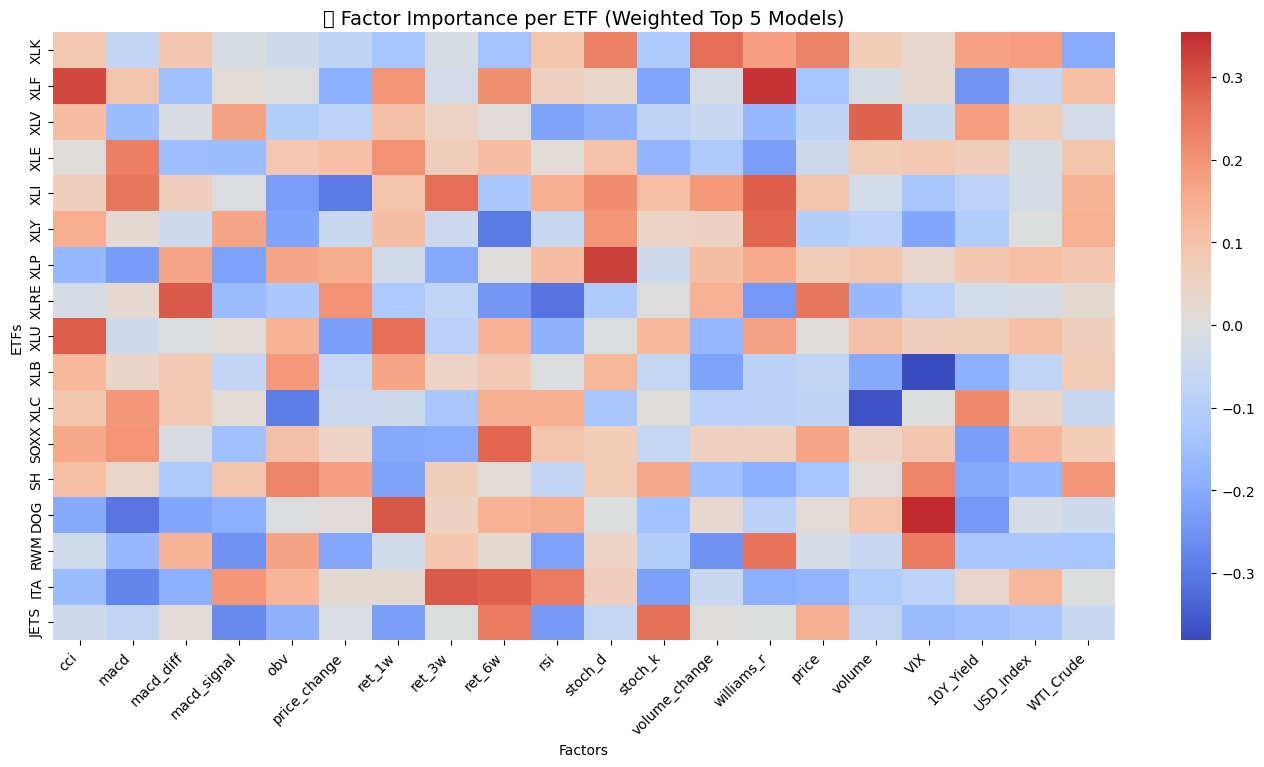

In [23]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Config ===
weights_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
feature_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
ETF_LIST = ['XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLRE', 'XLU', 'XLB', 'XLC', 'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'JETS']

# === Storage ===
factor_weights = {}

# === Extract input dimension ===
first_etf = ETF_LIST[0]
example_path = os.path.join(feature_dir, f'{first_etf}_combined.csv')
example_features = pd.read_csv(example_path, index_col=0)
factor_names = example_features.columns.tolist()

# === Aggregate top 5 weights for each ETF
for etf in ETF_LIST:
    weights = []
    for i in range(1, 6):
        model_path = os.path.join(weights_dir, f"{etf}_top{i}.pt")
        if os.path.exists(model_path):
            data = torch.load(model_path, map_location='cpu')
            linear_weights = data['weights']['output.weight'].squeeze().numpy()
            weights.append(linear_weights * data['weight'])  # weighted by performance
    if weights:
        factor_weights[etf] = sum(weights)

# === Create DataFrame for heatmap
weight_df = pd.DataFrame(factor_weights, index=factor_names)
weight_df = weight_df.T  # shape: (ETF, Factors)

# === Plot ===
plt.figure(figsize=(14, 8))
sns.heatmap(weight_df, cmap="coolwarm", annot=False, center=0)
plt.title("🎯 Factor Importance per ETF (Weighted Top 5 Models)", fontsize=14)
plt.xlabel("Factors")
plt.ylabel("ETFs")
plt.tight_layout()
plt.xticks(rotation=45, ha="right")
plt.show()


In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.gridspec as gridspec

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
etf_list = ['XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLRE', 'XLU', 'XLB', 'XLC', 'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'JETS']

# === Model (same as training)
class DualTransformerModel(nn.Module):
    def __init__(self, num_features, hidden_dim=128, nhead=4, num_layers=2):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=num_features, nhead=nhead, dim_feedforward=hidden_dim, batch_first=True),
            num_layers=num_layers
        )
        self.output = nn.Linear(num_features, 1)

    def forward(self, x, mask):
        x_masked = x * (1 - mask)
        x_seq = x_masked.unsqueeze(1)
        enc = self.encoder(x_seq).squeeze(1)
        return self.output(enc).squeeze(-1)

# === Gather predictions
plot_data = []

for etf in etf_list:
    try:
        feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
        mask_path = os.path.join(data_dir, f"{etf}_mask.csv")
        model_path = os.path.join(model_dir, f"{etf}_top1.pt")

        X = pd.read_csv(feat_path, index_col=0).astype('float32')
        M = pd.read_csv(mask_path, index_col=0).astype('float32')
        y = X.iloc[1:, 0].values
        X = X.iloc[:-1]
        M = M.iloc[:-1]

        model = DualTransformerModel(num_features=X.shape[1])
        model.load_state_dict(torch.load(model_path)['weights'])
        model.eval()

        with torch.no_grad():
            pred = model(torch.tensor(X.values), torch.tensor(M.values)).numpy()

        df = pd.DataFrame({'Date': X.index, 'Predicted': pred, 'Actual': y}).set_index('Date')
        plot_data.append((etf, df.iloc[-50:]))

    except Exception as e:
        print(f"⚠️ Error loading/predicting {etf}: {e}")

# === Plotting
fig = plt.figure(figsize=(20, 4 * ((len(plot_data) + 3) // 4)))
gs = gridspec.GridSpec((len(plot_data) + 3) // 4, 4, figure=fig)

for i, (etf, df) in enumerate(plot_data):
    ax = fig.add_subplot(gs[i])
    ax.plot(df.index, df['Actual'], label='Actual', color='blue')
    ax.plot(df.index, df['Predicted'], label='Predicted', color='red')
    ax.set_title(etf)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("ETF Weekly Return Prediction vs. Actual", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_33048\3743958291.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location='cpu')


KeyError: 'model.0.weight'

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")


CUDA available: True
CUDA version: 11.8
Device count: 1
Device name: NVIDIA GeForce RTX 3080
